In [144]:
# Final Project - NHANES 2013-2014 Age Group Classification: Age & Diabetes
# Data Mining & Text Analytics - MATH 3310 - Fall 2025

# This script:
#   - Loads a prepared NHANES 2013–2014 subset (CSV)
#   - Performs basic data checks and exploratory data analysis
#   - Builds preprocessing + modeling pipelines with ColumnTransformer
#   - Task 1: Age-group classification (Teen vs Adult)
#       * Baseline Logistic Regression vs Random Forest classifier model comparison
#       * Hyperparameter tuning with GridSearchCV for Random Forest since it outperformed LR
#       * Stratified 5-fold cross-validation
#       * Comparison of metrics and simple feature interpretation
#   - Task 2: Diabetes-risk classification (binary label from DIQ010)
#       * Baseline Logistic Regression and Random Forest
#       * Grid search over RF hyperparameters
#       * Cross-validation strategy comparison (StratifiedKFold vs KFold)
#       * Class-weighted Random Forest models
#       * SMOTE + Random undersampling + Random Forest
#       * Summary table of accuracy, error rate, balanced accuracy, F1, G-mean
#       * Feature importance (MDI, permutation, optional SHAP)
#   - Contains a written reflection / discussion block (for report) at the end

In [186]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score as gmean_score

In [146]:
def evaluate_classifier(model, X_train, X_test, y_train, y_test, target_name=""):
    """
    Fit a classifier, evaluate on test, and print metrics.
    Returns (y_test_pred, metrics_dict).
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For ROC-AUC, need predicted probabilities (if available)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_prob)
    else:
        roc = np.nan

    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    gm = gmean_score(y_test, y_pred)

    print(f"=== {target_name} — Test Set Metrics ===")
    print(f"Accuracy:           {acc:.4f}")
    print(f"Balanced accuracy:  {bal_acc:.4f}")
    print(f"F1 score (pos=1):   {f1:.4f}")
    print(f"G-mean:             {gm:.4f}")
    if not np.isnan(roc):
        print(f"ROC-AUC:            {roc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred), "\n")

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()
    plt.title(f"{target_name} — Confusion Matrix (Test)")
    plt.tight_layout()
    plt.show()

    metrics = {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "f1": f1,
        "gmean": gm,
        "roc_auc": roc,
    }
    return y_pred, metrics

In [147]:
# Read file

# Define the relative path to the CSV file
file_path = '..\\data\\raw\\NHANES_age_prediction.csv'

# Read the CSV file into a DataFrame
try:
    df = pd.read_csv(file_path)
    print(df.head())
except Exception as e:
    print(f"An error occurred: {e}")

      SEQN age_group  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  \
0  73564.0     Adult      61.0       2.0     2.0    35.7   110.0     2.0   
1  73568.0     Adult      26.0       2.0     2.0    20.3    89.0     2.0   
2  73576.0     Adult      16.0       1.0     2.0    23.2    89.0     2.0   
3  73577.0     Adult      32.0       1.0     2.0    28.9   104.0     2.0   
4  73580.0     Adult      38.0       2.0     1.0    35.9   103.0     2.0   

   LBXGLT  LBXIN  
0   150.0  14.91  
1    80.0   3.85  
2    68.0   6.14  
3    84.0  16.15  
4    81.0  10.92  


In [148]:
# Display information about the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       2278 non-null   float64
 1   age_group  2278 non-null   object 
 2   RIDAGEYR   2278 non-null   float64
 3   RIAGENDR   2278 non-null   float64
 4   PAQ605     2278 non-null   float64
 5   BMXBMI     2278 non-null   float64
 6   LBXGLU     2278 non-null   float64
 7   DIQ010     2278 non-null   float64
 8   LBXGLT     2278 non-null   float64
 9   LBXIN      2278 non-null   float64
dtypes: float64(9), object(1)
memory usage: 178.1+ KB
None


In [168]:
# Rename columns for clarity and check for missing values

df.rename(columns={
    'SEQN': 'ID',
    'RIDAGEYR': 'Age',
    'RIAGENDR': 'Gender',
    'PAQ605': 'Physical_Activity',
    'BMXBMI': 'BMI',
    'LBXGLU': 'Glucose_Level',
    'DIQ010': 'Diabetes_Status',
    'LBXGLT': 'Oral_Glucose_Test',
    'LBXIN': 'Insulin_Level'}, inplace=True)


print(df.isnull().sum())
print(f'Age Group            {df['age_group'].isnull().sum()}')

ID                   0
age_group            0
Age                  0
Gender               0
Physical_Activity    0
BMI                  0
Glucose_Level        0
Diabetes_Status      0
Oral_Glucose_Test    0
Insulin_Level        0
dtype: int64
Age Group            0


In [150]:
# Split the data into features and target variable
X_agegroup = df.drop(columns=['age_group'])
y_agegroup = df['age_group']

In [151]:
# check for impossible negative values
(X_agegroup < 0).sum()

ID                   0
Age                  0
Gender               0
Physical_Activity    0
BMI                  0
Glucose_Level        0
Diabetes_Status      0
Oral_Glucose_Test    0
Insulin_Level        0
dtype: int64

In [152]:
# change the physical activity where it is 7 to a 2 because 7 must have been a mistake
X_agegroup['Physical_Activity'] = X_agegroup['Physical_Activity'].replace(7, 2)
X_agegroup.drop(columns=['ID', 'Age'], inplace=True)

# drop ID because it has no predictive power, age is represented in the target variable

# get description of data
print(X_agegroup.describe())

            Gender  Physical_Activity          BMI  Glucose_Level  \
count  2278.000000        2278.000000  2278.000000    2278.000000   
mean      1.511414           1.820457    27.955180      99.553117   
std       0.499979           0.383891     7.248962      17.889834   
min       1.000000           1.000000    14.500000      63.000000   
25%       1.000000           2.000000    22.800000      91.000000   
50%       2.000000           2.000000    26.800000      97.000000   
75%       2.000000           2.000000    31.200000     104.000000   
max       2.000000           2.000000    70.100000     405.000000   

       Diabetes_Status  Oral_Glucose_Test  Insulin_Level  
count      2278.000000        2278.000000    2278.000000  
mean          2.016242         114.978929      11.834794  
std           0.185556          47.061239       9.718812  
min           1.000000          40.000000       0.140000  
25%           2.000000          87.000000       5.860000  
50%           2.000000  

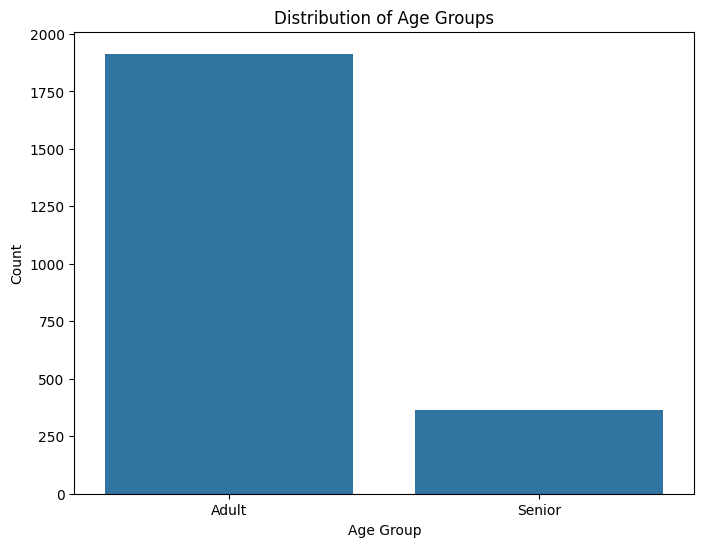

In [153]:
# graph the target variable to test for imbalance

plt.figure(figsize=(8, 6))
sns.countplot(x=y_agegroup)
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

In [154]:
# this is pretty unbalanced so we will have to stratify when we split the data later!
# split the data into training and testing sets with stratification

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_agegroup, y_agegroup, test_size=0.2, stratify=y_agegroup, random_state=1001)
print("Training set class distribution:")
print(y_train_age.value_counts(normalize=True))
print("\nTesting set class distribution:")
print(y_test_age.value_counts(normalize=True))

Training set class distribution:
age_group
Adult     0.840285
Senior    0.159715
Name: proportion, dtype: float64

Testing set class distribution:
age_group
Adult     0.839912
Senior    0.160088
Name: proportion, dtype: float64


In [155]:
# prepare lists of numerical and categorical features for pipeline
age_numerical_features = X_agegroup.select_dtypes(include=['int64', 'float64']).columns.tolist()
age_categorical_features = X_agegroup.select_dtypes(include=['object', 'category']).columns.tolist()

In [156]:
feature_selector = SelectFromModel(
    RandomForestClassifier(
        n_estimators=300,
        random_state=1001
    ),
    threshold="median"   
)

In [157]:
# define preprocessing pipelines for numerical and categorical data

age_numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))
])
age_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
age_preprocessor = ColumnTransformer(
    transformers=[
        ("num", age_numerical_transformer, age_numerical_features),
        ("cat", age_categorical_transformer, age_categorical_features),
    ]
)
age_preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [167]:
# Baseline Logistic Regression model for Age Group classification

age_pipe = Pipeline(steps=[
    ('preprocessor', age_preprocessor),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=927), threshold='median')),
    ('classifier', RandomForestClassifier(n_estimators=500, random_state=927))
])
age_pipe.fit(X_train_age, y_train_age)

,steps,"[('preprocessor', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [159]:
param_grid_age = [
    {
        'classifier': [LogisticRegression(max_iter=2000, solver="liblinear")],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2']
    },
    {
        'classifier': [RandomForestClassifier(random_state=0)],
        'classifier__n_estimators': [100, 300, 500,1000]
    }
]

In [160]:
# apply grid search

kf_age = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)
gs_age = GridSearchCV(age_pipe, param_grid_age, cv=kf_age, scoring='balanced_accuracy')

In [161]:
gs_age.fit(X_train_age, y_train_age)

,estimator,Pipeline(step...mators=500))])
,param_grid,"[{'classifier': [LogisticRegre...r='liblinear')], 'classifier__C': [0.01, 0.1, ...], 'classifier__penalty': ['l2']}, {'classifier': [RandomForestC...andom_state=0)], 'classifier__n_estimators': [100, 300, ...]}]"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [162]:
print(f' Best Parameters: {gs_age.best_params_}')
print(f'Best Score: {gs_age.best_score_:.4f}')
best_model_age = gs_age.best_estimator_


 Best Parameters: {'classifier': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 100}
Best Score: 0.5826


In [163]:
# stratified 5-fold cross-validation for Random Forest on Age Group classification

cv_scores_age = cross_val_score(
    best_model_age,
    X_train_age,
    y_train_age,
    cv=5,
    scoring="balanced_accuracy"
)

print(cv_scores_age)
print("Mean CV balanced accuracy for Logistic Regression Model on Age Group Classification:", cv_scores_age.mean())

[0.54655478 0.5839043  0.55961235 0.54563895 0.59944783]
Mean CV balanced accuracy for Logistic Regression Model on Age Group Classification: 0.5670316406105108


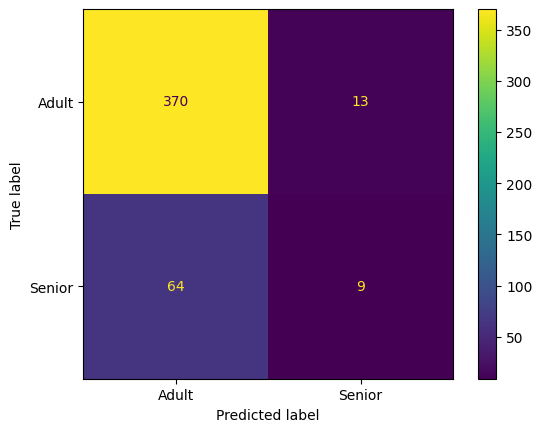

In [169]:
y_pred_test_age = best_model_age.predict(X_test_age)
ConfusionMatrixDisplay.from_estimator(best_model_age, X_test_age, y_test_age)

In [187]:
# define imbalanced pipeline

imb_pipe_age = ImbPipeline(steps=[('preprocessor', age_preprocessor),
                ('oversample', SMOTE()),
                ('undersample', RandomUnderSampler(random_state=42)),  
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [189]:
imb_gs_age = GridSearchCV(imb_pipe_age, param_grid_age, cv=kf_age, scoring='balanced_accuracy')
imb_gs_age.fit(X_train_age, y_train_age)

,estimator,Pipeline(step...om_state=0))])
,param_grid,"[{'classifier': [LogisticRegre...r='liblinear')], 'classifier__C': [0.01, 0.1, ...], 'classifier__penalty': ['l2']}, {'classifier': [RandomForestC...andom_state=0)], 'classifier__n_estimators': [100, 300, ...]}]"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [190]:
print(f' Best Parameters: {gs_age.best_params_}')
print(f'Best Score: {gs_age.best_score_:.4f}')
best_model_age = gs_age.best_estimator_

 Best Parameters: {'classifier': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 100}
Best Score: 0.5826


In [ ]:
cv_scores_age = cross_val_score(
    best_model_age,
    X_train_age,
    y_train_age,
    cv=5,
    scoring="balanced_accuracy"
)

print(cv_scores_age)
print("Mean CV balanced accuracy for Random Forest Classifier Model on Age Group Classification:", cv_scores_age.mean())

[0.54655478 0.5839043  0.55961235 0.54563895 0.59944783]
Mean CV balanced accuracy for Logistic Regression Model on Age Group Classification: 0.5670316406105108


In [192]:
cv_scores_age = cross_val_score(
    best_model_age,
    X_train_age,
    y_train_age,
    cv=kf_age,
    scoring="balanced_accuracy",
    n_jobs=-1,
)

print("=== Age-group: Random Forest (Stratified 5-fold CV) ===")
print(f"Mean CV balanced accuracy: {cv_scores_age.mean():.4f}")
print(f"Std CV balanced accuracy:  {cv_scores_age.std():.4f}")
print("Fold scores:", cv_scores_age, "\n")

y_age_pred_rf, age_rf_metrics = evaluate_classifier(
    best_model_age,
    X_train_age,
    X_test_age,
    y_train_age,
    y_test_age,
    target_name="Age-group (Random Forest)",
)

=== Age-group: Random Forest (Stratified 5-fold CV) ===
Mean CV balanced accuracy: 0.5826
Std CV balanced accuracy:  0.0213
Fold scores: [0.58208707 0.60440301 0.59364435 0.59037638 0.54237097] 



ValueError: pos_label=1 is not a valid label. It should be one of ['Adult', 'Senior']

In [193]:
# Task 2: Diabetes-risk classification (binary label from DIQ010)

X_diabetes = df.drop(columns=['Diabetes_Status'])
y_diabetes = df['Diabetes_Status']

In [ ]:
# unique rows in diabetes status
# 1 means yes, 2 means no, 3 means borderline, 7 and 9 means refused/don't know
print(y_diabetes.value_counts())

Diabetes_Status
2.0    2199
3.0      58
1.0      21
Name: count, dtype: int64


In [ ]:
diab_df = df[df["DIQ010"].isin([1, 2, 3])].copy()